# Line fitting

The objective is to provide a traffic lane detector based on Hough transform, without using existing libraries for computer vision (openCV,...)

In [2]:
import numpy as np
import csv
import cv2 
%matplotlib inline 
import matplotlib.pyplot as plt
import math

import scipy.ndimage.filters as filters
import scipy.ndimage as ndimage

# Final pipeline

## Function for image pre-processing 

In [3]:
def image_preprocessing(image,gamma,kernel_size):
    '''
    Preprocess the image to extract lane line edges.  
    '''
    
    # Color image
    img = cv2.imread(image) 
    # Grayscale image 
    gray_img =  cv2.imread(image,cv2.IMREAD_GRAYSCALE)
    
    # Darken the grayscale image
    darkened_img = adjust_gamma(gray_img, 0.5)
    
    # Select white pixels
    white_mask = isolate_color_mask(cv2.cvtColor(img, cv2.COLOR_RGB2HLS), np.array([0, 200, 0], dtype=np.uint8), np.array([200, 255, 255], dtype=np.uint8))
    colored_img = cv2.bitwise_and(darkened_img, darkened_img, mask=white_mask)
    
    # Apply Gaussian Blur
    blurred_img = gaussian_blur(colored_img, kernel_size=7)
    
    # Canny Edge Detector
    canny_img =  cv2.Canny(blurred_img,50,150)
    
    # Get Area of Interest
    aoi_img = get_aoi(canny_img)
    cv2.imwrite('edges.png',aoi_img)
    
    return aoi_img

## Function to return detected lane lines in an image using Hough transform

In [4]:
def hough_lines(image, gamma, kernel_size, r_dim, theta_dim, neighborhood_size, threshold, col, thck):
    '''
    Return the original image with lane lines detected using Hough transform.  
    '''
    
    aoi_img = image_preprocessing(image,gamma,kernel_size)
    
    img_shape = aoi_img.shape
    
    x_max = img_shape[0]
    y_max = img_shape[1]

    theta_max = 1.0 * math.pi 
    theta_min = 0.0

    r_min = 0.0
    r_max = int(math.hypot(x_max, y_max))
    
    # Build and fill the accumulator
    accumulator = hough_space(aoi_img, r_dim, theta_dim)
    
    # Find extremas of accumulator
    rho_idxs, theta_idxs = find_extremas(accumulator, neighborhood_size, threshold)
    
    #Plot image with detected lines 
    plot_detected_lines(image, rho_idxs, theta_idxs, r_dim, r_max, theta_dim, theta_max, col, thck)
    


# Helper function definitions and detailed example

## Step 1 - Load the image

In [5]:
# Color
img = cv2.imread("data/001109.png")

# Grayscale
gray_img =  cv2.imread("data/001109.png",cv2.IMREAD_GRAYSCALE)

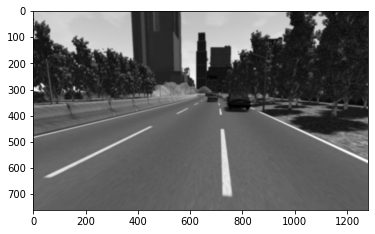

In [6]:
plt.imshow(gray_img, cmap = "gray", interpolation = "bicubic")

## Step 2 - Preprocessing & Edge detection

### Darken the grayscale image

In [7]:
# function to darken a grayscale image by adjusting the gamma
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
 
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

In [8]:
# darken the grayscale
darkened_img = adjust_gamma(gray_img, 0.5)
   

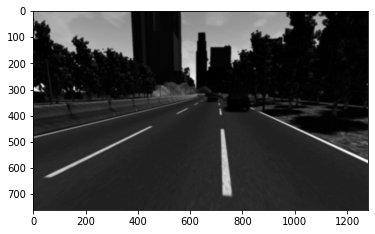

In [9]:
plt.imshow(darkened_img, cmap = "gray", interpolation = "bicubic")

### Selecting white pixels 

In [10]:
# Function to isolate pixels of a specific color
def isolate_color_mask(img, low_thresh, high_thresh):
    assert(low_thresh.all() >=0  and low_thresh.all() <=255)
    assert(high_thresh.all() >=0 and high_thresh.all() <=255)
    return cv2.inRange(img, low_thresh, high_thresh)

In [11]:
# Color Selection
white_mask = isolate_color_mask(cv2.cvtColor(img, cv2.COLOR_RGB2HLS), np.array([0, 200, 0], dtype=np.uint8), np.array([200, 255, 255], dtype=np.uint8))
colored_img = cv2.bitwise_and(darkened_img, darkened_img, mask=white_mask)

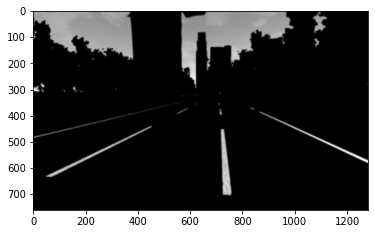

In [12]:
plt.imshow(colored_img, cmap = "gray", interpolation = "bicubic")

### Reducing noise

In [13]:
# Function to apply a gaussian filter to reduce noise
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

In [14]:
# Apply Gaussian Blur
blurred_img = gaussian_blur(colored_img, kernel_size=7)
   

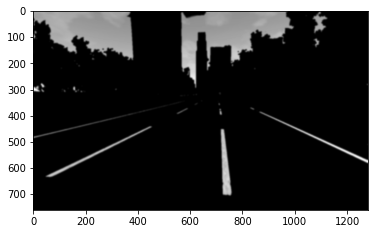

In [15]:
plt.imshow(blurred_img, cmap = "gray", interpolation = "bicubic")

### Applying Canny Edge detection

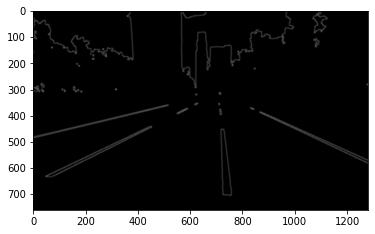

In [16]:
# Canny Edge Detector
canny_img =  cv2.Canny(blurred_img,50,150)
plt.imshow(canny_img, cmap = "gray", interpolation = "bicubic")

### Select Region of Interest

In [17]:
# Functions to select Region of interest (i.e the road here)

# Defining a region of interest
def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


# Extracting region of interest from an image
def get_aoi(img):
    rows, cols = img.shape[:2]
    mask = np.zeros_like(img)
    
    left_bottom1 = [cols * 0.01, rows]
    left_bottom2 = [cols * 0.01, rows* 0.6]
    right_bottom1 = [cols * 0.99, rows]
    right_bottom2 = [cols * 0.99, rows* 0.6]
    
    left_top = [cols * 0.5, rows * 0.43]
    right_top = [cols * 0.6, rows * 0.43]

    
    vertices = np.array([[left_bottom1, left_bottom2, left_top, right_top, right_bottom2 ,right_bottom1]], dtype=np.int32)
    
    if len(mask.shape) == 2:
        cv2.fillPoly(mask, vertices, 255)
    else:
        cv2.fillPoly(mask, vertices, (255, ) * mask.shape[2])
        
    return cv2.bitwise_and(img, mask)

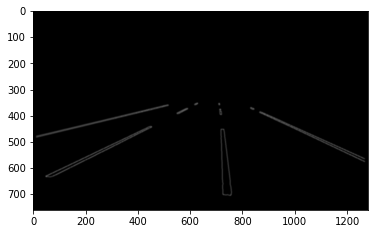

In [18]:
# Get Area of Interest
aoi_img = get_aoi(canny_img)

plt.imshow(aoi_img, cmap = "gray", interpolation = "bicubic")

## Step 3 - Hough space

In [19]:
img_shape = aoi_img.shape
    
x_max = img_shape[0]
y_max = img_shape[1]

theta_max = 1.0 * math.pi 
theta_min = 0.0

r_min = 0.0
r_max = int(math.hypot(x_max, y_max))

r_dim = 300
theta_dim = 180

In [20]:
def hough_space(img,r_dim,theta_dim):
    
    accumulator = np.zeros((r_dim,theta_dim))
    
    x_idxs, y_idxs = np.nonzero(img)  # (row, col) indexes to edges

    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]    

        for itheta in range(theta_dim):
            theta = 1.0 * itheta * theta_max / theta_dim
            r = x * math.cos(theta) + y * math.sin(theta)
            ir = int(r_dim * ( 1.0 * r ) / r_max)
            accumulator[ir,itheta] += 1

    return accumulator

In [21]:
accumulator = hough_space(aoi_img,r_dim,theta_dim)

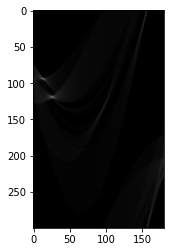

In [22]:
plt.imshow(accumulator, cmap = "gray", interpolation = "bicubic")

## Step 4 - Find extrema

In [23]:
def find_extremas(accumulator, neighborhood_size, threshold):
    data_max = filters.maximum_filter(accumulator, neighborhood_size)
    maxima = (accumulator == data_max)


    data_min = filters.minimum_filter(accumulator, neighborhood_size)
    diff = ((data_max - data_min) > threshold)
    maxima[diff == 0] = 0

    labeled, num_objects = ndimage.label(maxima)
    slices = ndimage.find_objects(labeled)

    theta_idxs, rho_idxs = [], []
    for dy,dx in slices:
        x_center = (dx.start + dx.stop - 1)/2
        theta_idxs.append(x_center)
        y_center = (dy.start + dy.stop - 1)/2    
        rho_idxs.append(y_center)

    print(theta_idxs)
    print(rho_idxs)

    plt.imshow(accumulator, origin='lower')
    plt.savefig('hough_space_i_j.png', bbox_inches = 'tight')

    plt.autoscale(False)
    plt.plot(theta_idxs,rho_idxs, 'ro')
    plt.savefig('hough_space_maximas.png', bbox_inches = 'tight')

    plt.close()
    
    return rho_idxs, theta_idxs

In [24]:
rho_idxs, theta_idxs=find_extremas(accumulator, neighborhood_size=20, threshold=100)

[156.0, 13.0, 27.0, 92.0, 179.0, 172.0, 166.0, 157.0]
[0.0, 94.0, 120.0, 141.0, 225.0, 242.0, 253.0, 296.0]


In [25]:
def plot_detected_lines(image, rho_idxs, theta_idxs, r_dim, r_max, theta_dim, theta_max, col, thck):
    
    img = cv2.imread(image) 
        
    for i in range(len(rho_idxs)):
        rho = rho_idxs[i] * r_max /r_dim 
        theta = theta_idxs[i] * theta_max / theta_dim

        a = math.cos(theta)
        b = math.sin(theta)
        x = a * rho
        y = b * rho
        #pt1 = (int(x + 1000*(-b)), int(y + 1000*(a)))
        #pt2 = (int(x - 1000*(-b)), int(y - 1000*(a)))
        pt1 = ( int(y + 1000*(a)),int(x + 1000*(-b)))
        pt2 = (int(y - 1000*(a)),int(x - 1000*(-b)))
        print(pt1,pt2)

        cv2.line(img,pt1,pt2,col,thck)

    cv2.imwrite('ref_res.png',img)



In [27]:
plot_detected_lines("data/001109.png", rho_idxs, theta_idxs, r_dim, r_max, theta_dim, theta_max, col=(0,0,255), thck=10)

(-913, -406) (913, 406)
(1079, 229) (-869, 679)
(1161, 76) (-620, 984)
(664, -1023) (733, 974)
(-980, -1133) (1019, -1098)
(-823, -1327) (1157, -1049)
(-666, -1459) (1273, -975)
(-346, -1742) (1494, -960)


# Direct application of the pipeline to the example image

In [29]:
hough_lines(image="data/001109.png", gamma=0.5, kernel_size=7, r_dim=300, theta_dim=180, neighborhood_size=20, threshold=100, col=(0,0,255), thck=10)

[156.0, 13.0, 27.0, 92.0, 179.0, 172.0, 166.0, 157.0]
[0.0, 94.0, 120.0, 141.0, 225.0, 242.0, 253.0, 296.0]
(-913, -406) (913, 406)
(1079, 229) (-869, 679)
(1161, 76) (-620, 984)
(664, -1023) (733, 974)
(-980, -1133) (1019, -1098)
(-823, -1327) (1157, -1049)
(-666, -1459) (1273, -975)
(-346, -1742) (1494, -960)
